In [ ]:
# Run this cell and restart the kernel if the libraries are not present in the environment
! pip install --upgrade --quiet pinecone-client==2.2.4  dominodatalab-data==5.10.0.dev2 

In [112]:
%run /mnt/code/utils/eval.ipynb

In [ ]:
%run /mnt/code/utils/graph_RAG_chain.ipynb # get the graph rag chain; the chain is in a variable called chain

In [ ]:
# Load all the dependencies
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone

from domino_data.vectordb import DominoPineconeConfiguration

import pinecone
import csv
import time

In [185]:
def run_eval(input_file):
    # Get the results for graph RAG ; uncomment the sleeps if you have low rate limits with OpenAI
    graph_llm_results = get_llm_results(chain,input_file,output_eval_file='/mnt/code/data/graph_rag_eval.csv',chain_type='graph')
    # time.sleep(60)  # Introduces a 60-second delay
    qa_llm_results = get_llm_results(qa_rag_chain,input_file,output_eval_file='/mnt/code/data/qa_rag_eval.csv', chain_type='qa')
    # time.sleep(60)  # Introduces a 60-second delay
    graph_rag_scores = get_match_scores("/mnt/code/data/graph_rag_eval.csv")
    # time.sleep(60)  # Introduces a 60-second delay
    qa_rag_scores = get_match_scores("/mnt/code/data/qa_rag_eval.csv")
    plot_match_scores_distributions(graph_rag_scores, qa_rag_scores)
    return graph_rag_scores, qa_rag_scores

In [110]:
def get_llm_results(qa_chain, input_data_file, output_eval_file, chain_type='graph'):
    # read the question, get the llm response
    # write the question, llm response and gt to a new csv; overwrite if exists
    # Get the results for non graph QA RAG
    df = pd.read_csv(input_data_file)

    # Running the first 20 to avoid rate limits, uncomment if you have low rate limits with OpenAI
    # df = df[:20]
    
    # Extract column values
    questions = df['question'].tolist()
    gt_answers = df['gt_answer'].tolist()
    
    # Format the data
    if chain_type.lower() == 'graph':
        batch_data = [{"question": question} for question in questions]
    else:
        batch_data = [question for question in questions]        
    
    # Call chain.batch
    results = qa_chain.batch(batch_data)   
    
    # Column headers for each list
    headers = ['llm_answer', 'gt_answer']
    # Writing to the CSV file so they can be analyzed later
    with open(output_eval_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write the headers
        writer.writerow(headers)
        
        # Assuming all lists are of the same length
        for i in range(len(gt_answers)):
            writer.writerow([results[i], gt_answers[i]])
            
    print(f"{output_eval_file} generated")

In [ ]:
def insert_wikpage_into_pinecone(wiki_page="Elon Musk"):
   
    datasource_name = "GraphRAGEval"
    conf = DominoPineconeConfiguration(datasource=datasource_name)
    # The pinecone API key should be provided when creating the Domino Data Source and persisted securely.
    # This api_key variable here is only used for satisfying the native pinecone python client initialization where
    # api_key is a mandatory non-empty field.
    api_key = os.environ.get("DOMINO_VECTOR_DB_METADATA", datasource_name)
    
    pinecone.init(
        api_key=api_key,
        environment="domino",
        openapi_config=conf)
    
    #check if index already exists, if not we create it
    index_name = "graph-rag-eval"
    if index_name not in pinecone.list_indexes():
        pinecone.create_index(
            name=index_name,
            dimension=1536, ## 1536 for openai embeddings 
            metric='cosine'
        )
    
    #insert the embeddings

    # Read the wikipedia article
    raw_documents = WikipediaLoader(query=wiki_page).load()
    # Define chunking strategy
    text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
    documents = text_splitter.split_documents(raw_documents[:3])
    
    vector_store = Pinecone.from_documents(
        documents,
        embedding=OpenAIEmbeddings(),
        index_name=index_name
    )
    
    return vector_store

In [ ]:
# Insert the wikipage into Pinecone so it can be used as a knowledge base for the QA RAG
vectorstore = insert_wikpage_into_pinecone()

In [ ]:
# Retrieve and generate using the relevant snippets
qa_rag_retriever = vectorstore.as_retriever()

qa_rag_template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.

{context}

Question: {question}

Helpful Answer:"""
qa_rag_prompt = PromptTemplate.from_template(qa_rag_template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


qa_rag_chain = (
    {"context": qa_rag_retriever | format_docs, "question": RunnablePassthrough()}
    | qa_rag_prompt
    | llm
    | StrOutputParser()
)

Search query: Which companies is Elon Musk associated with?
Search query: What companies and technologies is Elon involved with?
Search query: Who are Elon Musk's family members?
Search query: What political issues is Elon associated with?
Search query: Which political parties has Elon Musk supported?
Search query: Who has Elon Musk praised?
/mnt/code/data/graph_rag_eval.csv generated
/mnt/code/data/qa_rag_eval.csv generated


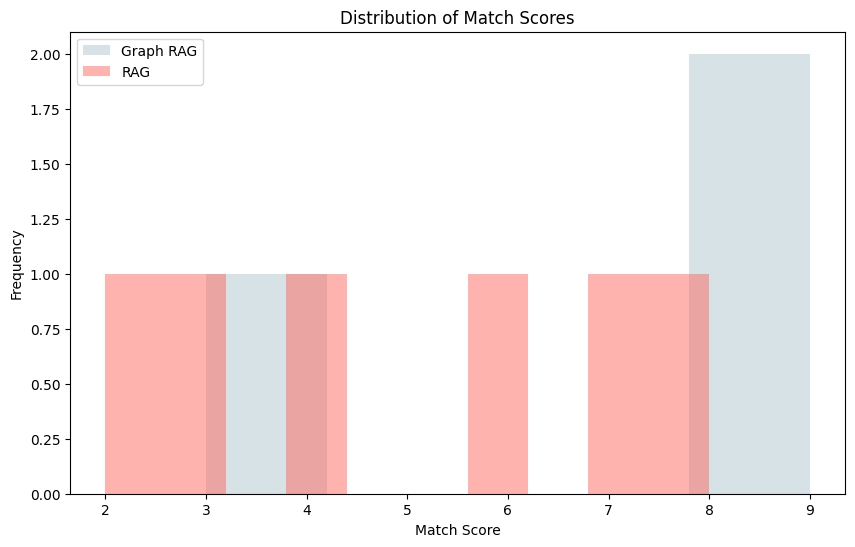

The median match score for Graph RAG is: 8.0
The median match score for RAG is: 5.0


In [186]:
# Run an evaluation on questions that have more relation components to them
graph_rag_scores, qa_rag_scores = run_eval(input_file='/mnt/code/data/elon_eval_rel.csv')

Search query: What led Elon Musk to move from South Africa to Canada?
Search query: What was Elon Musk's educational path after moving to Canada?
Search query: What was the financial outcome for Musk from the sale of Zip2 to Compaq?
Search query: What was Musk's role and subsequent change in position at PayPal?
Search query: How did Elon Musk's early interest in computers manifest at the age of 12?
Search query: What was the outcome of Musk's university-level aptitude test in computer programming?
Search query: How did Musk's experience with his father influence his decision to live with him after his parents' divorce?
Search query: How did Musk's creation of X.com lead to the formation of PayPal?
Search query: How did Musk's first company, Zip2, provide value to newspapers like The New York Times and Chicago Tribune?
Search query: How did Musk's nightclub venture during his University of Pennsylvania days reflect his entrepreneurial spirit?
Search query: What prompted Musk to leave St

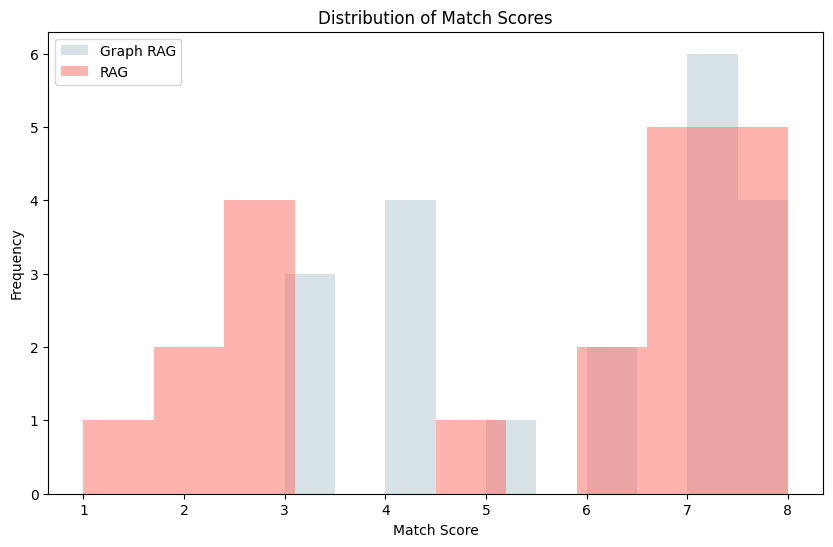

The median match score for Graph RAG is: 6.5
The median match score for RAG is: 6.5


In [187]:
# Run an evaluation on general questions
graph_rag_scores, qa_rag_scores = run_eval(input_file='/mnt/code/data/elon_eval_qa.csv')